# User-Studies 

In [2546]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Data Processing

In [2548]:
# Read all files
pre_study = pd.read_csv('Data/IN5060_fall24-pre-study.csv')
during_study = pd.read_csv("Data/IN5060_fall24-during-study.csv")
post_study = pd.read_csv('Data/IN5060_fall24-post-study.csv')

print(f"Number of rows in pre_study before processing data: {pre_study.shape[0]}")
print(f"Number of rows in during_study before processing data: {during_study.shape[0]}")
print(f"Number of rows in post_study before processing data: {post_study.shape[0]}")
print(f"\n-------------------------------------------------------------------------------------------------------\n")

session_id_col = "Session ID (the last session that the participant has completed)"
participant_id_col = "Participant ID (top-right corner of the screen)"
participant_id_during_col = "Participant ID (top-right corner)"

# -------------------------------------------------------------------------------------------------------------------
# ---------------------- REMOVE DIRTY DATA --------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------
pre_study = pre_study[pre_study["Please indicate if you have any of the following health problems."] != "Test"]
during_study = during_study[~during_study[participant_id_during_col].str.contains("test", case=False, na=False)]

# Remove participant id "grup16"
pre_study = pre_study[pre_study[participant_id_col] != "grup16"]
during_study = during_study[during_study[participant_id_during_col] != "grup16"]
post_study = post_study[post_study[participant_id_col] != "grup16"]

# Remove participant ids containing "group15" in any dataset
pre_study = pre_study[~pre_study[participant_id_col].str.contains("group15", case=False)]
during_study = during_study[~during_study[participant_id_during_col].str.contains("group15", case=False)]
post_study = post_study[~post_study[participant_id_col].str.contains("group15", case=False)]

# Remove duplicate session id CYSP for participant id G17P4
g17p4_cysp = during_study[(during_study[participant_id_during_col] == "G17P4") & (during_study[session_id_col] == "CYSP")]
g17p4_cysp_sorted = g17p4_cysp.sort_values(by="Timestamp")
if not g17p4_cysp_sorted.empty:
    oldest_index = g17p4_cysp_sorted.index[0]
    during_study.at[oldest_index, session_id_col] = "ALICE"

# Print if there are duplicates for CYSP session ID for participant G17P4
print(f"Duplicate 'CYSP' session IDs for participant 'G17P4': {len(g17p4_cysp) > 1}")

# Print if any participant ID in any dataset contains "grup16"
print(f"Participant with ID 'grup16' in pre_study: {'grup16' in pre_study[participant_id_col].values}")
print(f"Participant with ID 'grup16' in during_study: {'grup16' in during_study[participant_id_during_col].values}")
print(f"Participant with ID 'grup16' in post_study: {'grup16' in post_study[participant_id_col].values}")

# Print the count of rows that had "group15" in the Participant ID for each dataset
print(f"Participant with ID 'grup15' in pre_study: {pre_study[pre_study[participant_id_col].str.contains('group15', case=False)].shape[0]}")
print(f"Participant with ID 'grup15' in during_study: {during_study[during_study[participant_id_during_col].str.contains('group15', case=False)].shape[0]}")
print(f"Participant with ID 'grup15' in post_study: {post_study[post_study[participant_id_col].str.contains('group15', case=False)].shape[0]}")

# -------------------------------------------------------------------------------------------------------------------
# ---------------------- ENSURE SESSION ID EQUALS VOYAGER, ILLIAC, CYSP OR ALICE ------------------------------------
# -------------------------------------------------------------------------------------------------------------------
switch_ids = ['VOYAGER', 'ILLIAC', 'CYSP', 'ALICE']
switch_rows = during_study[during_study[participant_id_during_col]
                            .str.contains('|'.join(switch_ids), case=False, na=False)]

# Swap Participant ID and Session ID for these rows
for index, row in switch_rows.iterrows():
    during_study.at[index, participant_id_during_col] = row[session_id_col]
    during_study.at[index, session_id_col] = row[participant_id_during_col]

# Fix writing mistakes
replacements = {
    r'(?i)ALLICE': 'ALICE',
    r'(?i)iliac': 'ILLIAC',
    r'(?i)ILLIAD': 'ILLIAC',
    r'(?i)Crysp': 'CYSP'
}

# Replace session IDs using the dictionary
for old_value, new_value in replacements.items():
    during_study[session_id_col] = \
        during_study[session_id_col].replace(
            to_replace=old_value, value=new_value, regex=True)

# After fixing swap and correcting writing, how many invalid sessions are left?
def get_invalid_sessions(df):
    return df[~df[session_id_col]
              .str.contains("VOYAGER|ILLIAC|CYSP|ALICE", case=False, na=False)]

invalid_sessions = get_invalid_sessions(during_study)
print(f"\nRows in during_study with invalid session IDs before: {invalid_sessions.shape[0]}")

# Invalid sessions contain 35 rows, they have been investigated and we can drop them
during_study = during_study.drop(invalid_sessions.index)

invalid_sessions = get_invalid_sessions(during_study)
print(f"Rows in during_study with invalid session IDs after: {invalid_sessions.shape[0]}")

# -------------------------------------------------------------------------------------------------------------------
# ---------------------- REMOVING PARTICIPANTS WHERE SESSION COUNT IS NOT 4 -----------------------------------------
# -------------------------------------------------------------------------------------------------------------------
# Group by Participant ID and check the number of unique session IDs
session_count_per_participant = during_study.groupby(participant_id_during_col)[session_id_col].nunique()

# Identify valid participants who have 4 unique session IDs
valid_participants = session_count_per_participant[session_count_per_participant == 4].index

# Display participants with valid session counts
print(f"Participants in during_study with valid session counts (equal to 4): {valid_participants.shape[0]} = {valid_participants.shape[0]*4} rows")

# Only keep valid participants
during_study = during_study.query(f"`{participant_id_during_col}` in @valid_participants")

# -------------------------------------------------------------------------------------------------------------------
# ---------------------- REMOVE INVALID PARTICIPANTS FROM PRE AND POST STUDY ----------------------------------------
# -------------------------------------------------------------------------------------------------------------------
valid_participant_ids = during_study[participant_id_during_col].unique()

# Remove rows in pre_study and post_study where the participant ID is not present in during_study
pre_study = pre_study[pre_study[participant_id_col].isin(valid_participant_ids)]
post_study = post_study[post_study[participant_id_col].isin(valid_participant_ids)]

# Pre and post study should have the same amount of participants and no duplicates
pre_study = pre_study.sort_values(by="Timestamp", ascending=False)
pre_study = pre_study.drop_duplicates(subset=participant_id_col, keep='first')
post_study = post_study.sort_values(by="Timestamp", ascending=False)
post_study = post_study.drop_duplicates(subset=participant_id_col, keep='first')

common_participant_ids_pre = pre_study[participant_id_col].isin(post_study[participant_id_col])
common_participant_ids_post = post_study[participant_id_col].isin(pre_study[participant_id_col])

# This leaves us with 76 participants
pre_study = pre_study[common_participant_ids_pre]
post_study = post_study[common_participant_ids_post]

# During_study should have 304 entries, we have 316 -> find the duplicates
pre_post_participant_ids = set(pre_study[participant_id_col].unique()).intersection(post_study[participant_id_col].unique())
during_not_in_pre_post = set(valid_participant_ids) - pre_post_participant_ids
print(f"\nParticipant IDs present in during_study but not in pre_study or post_study: {during_not_in_pre_post}")

participants_to_remove = {'JOJOSIWA', 'g17p2', 'G17P6'}
during_study = during_study[~during_study[participant_id_during_col].isin(participants_to_remove)]
print("Number of rows in during_study after removing invalid participants:", len(during_study))

# -------------------------------------------------------------------------------------------------------------------
print(f"\n-------------------------------------------------------------------------------------------------------\n")
print(f"Number of rows in pre_study before processing data: {pre_study.shape[0]}")
print(f"Number of rows in during_study before processing data: {during_study.shape[0]}")
print(f"Number of rows in post_study before processing data: {post_study.shape[0]}")

# Display all columns and expand display width
pd.set_option('display.max_columns', None)     # Show all columns
pd.set_option('display.width', 1000)           # Set the display width to fit large tables
pd.set_option('display.max_colwidth', None)    # Show full column content without truncation
pd.set_option('display.max_rows', None)        # Show all rows (remove this if there are too many rows)

print("\n")
#print(during_study.head(10))

Number of rows in pre_study before processing data: 154
Number of rows in during_study before processing data: 469
Number of rows in post_study before processing data: 122

-------------------------------------------------------------------------------------------------------

Duplicate 'CYSP' session IDs for participant 'G17P4': False
Participant with ID 'grup16' in pre_study: False
Participant with ID 'grup16' in during_study: False
Participant with ID 'grup16' in post_study: False
Participant with ID 'grup15' in pre_study: 0
Participant with ID 'grup15' in during_study: 0
Participant with ID 'grup15' in post_study: 0

Rows in during_study with invalid session IDs before: 35
Rows in during_study with invalid session IDs after: 0
Participants in during_study with valid session counts (equal to 4): 79 = 316 rows

Participant IDs present in during_study but not in pre_study or post_study: {'JOJOSIWA', 'g17p2', 'G17P6'}
Number of rows in during_study after removing invalid participants: 

# Testing data

In [2550]:
# Role
print(f"\n--------------------------------------What describes you the best?---------------------------------------------")
column_of_interest = "What describes you the best?"
answers_to_count = [
    "Student/semi-professional musician",
    "Avid music listener",
    "Professional musician",
    "Not particularly interested in music"
]

counts = {answer: pre_study[pre_study[column_of_interest] == answer].shape[0] for answer in answers_to_count}
for answer, count in counts.items():
    print(f"{answer}: {count} participants")

# Gender - this is skewed as there are more than double the amount of males - could run statistical significance test
print(f"\n------------------------------------------------Gender?--------------------------------------------------------")
column_of_interest = "Gender?"
answers_to_count = [
    "Prefer not to say",
    "Male",
    "Female"
]

counts = {answer: pre_study[pre_study[column_of_interest] == answer].shape[0] for answer in answers_to_count}
for answer, count in counts.items():
    print(f"{answer}: {count} participants")

# Control
print(f"\n------------------------------Who had the overall control of the interaction?----------------------------------")
column_of_interest = "Who had the overall control of the interaction?"
counts = post_study[column_of_interest].value_counts().sort_index()
for control_level, count in counts.items():
    print(f"{control_level}: {count}")

# Experience w/ AI for creativity
print(f"\n--How often do you use AI tools for creativity (e.g., writing, coding, music, fine arts, food recipes, etc.)?--")
column_of_interest = "How often do you use AI tools for creativity (e.g., writing, coding, music, fine arts, food recipes, etc.)?"
counts = pre_study[column_of_interest].value_counts().sort_index()
for control_level, count in counts.items():
    print(f"{control_level}: {count}")

# Comments
print(f"\n------------------------Please add if you have any comments, suggestions, or requests.-------------------------")
column_of_interest = "Please add if you have any comments, suggestions, or requests."
non_empty_comments = post_study[post_study[column_of_interest].str.strip().ne("") & post_study[column_of_interest].notna()]

print("Non-empty comments, suggestions, or requests:")
for comment in non_empty_comments[column_of_interest]:
    print(f"- {comment.strip()}")



--------------------------------------What describes you the best?---------------------------------------------
Student/semi-professional musician: 9 participants
Avid music listener: 32 participants
Professional musician: 1 participants
Not particularly interested in music: 7 participants

------------------------------------------------Gender?--------------------------------------------------------
Prefer not to say: 0 participants
Male: 52 participants
Female: 24 participants

------------------------------Who had the overall control of the interaction?----------------------------------
0: 16
1: 42
2: 9
3: 8
4: 1

--How often do you use AI tools for creativity (e.g., writing, coding, music, fine arts, food recipes, etc.)?--
0: 12
1: 14
2: 18
3: 22
4: 10

------------------------Please add if you have any comments, suggestions, or requests.-------------------------
Non-empty comments, suggestions, or requests:
- fix the tracking landscape. It's invisible and gets in the way when doi

# Correlation between experience with AI and perception of control

In [2552]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean and prepare data
pre_column = "How often do you use AI tools for creativity (e.g., writing, coding, music, fine arts, food recipes, etc.)?"
post_column = "Who had the overall control of the interaction?"

# Combine the pre and post study data while ensuring participant IDs are used to merge
combined_data = pd.merge(pre_study[[participant_id_col, pre_column]], 
                         post_study[[participant_id_col, post_column]], 
                         on=participant_id_col).dropna()

# Rename columns for clarity
combined_data.columns = ["Participant ID", "AI Usage Frequency", "Control Perception"]
palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

### Heatmap (Frequency Matrix)
Using a heatmap of the frequency counts between the two scales to explore trends in how Likert responses align. This allows us to see trends in response pairs (e.g., if high AI usage correlates with high participant control).

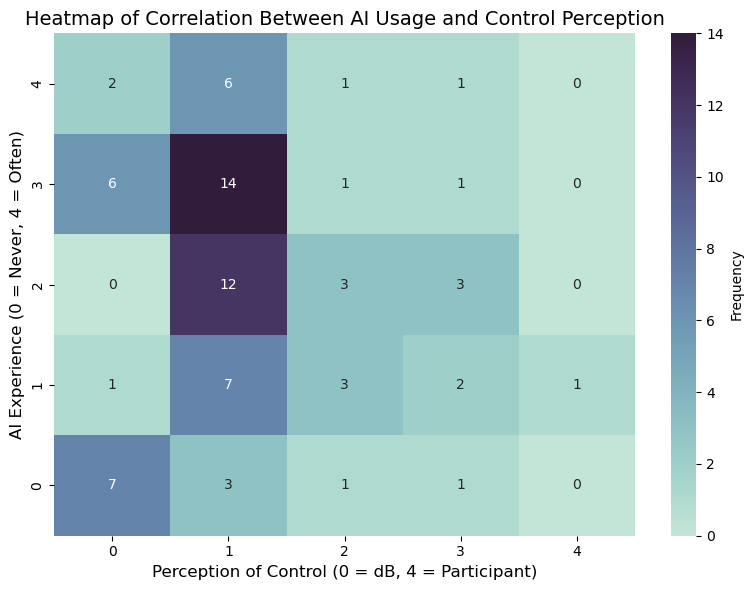

In [2554]:
import matplotlib.colors as mcolors

# Create the contingency table (counts of unique combinations of responses by participants)
heatmap_data = pd.crosstab(
    combined_data["AI Usage Frequency"],
    combined_data["Control Perception"]
)

#heatmap_palette = sns.color_palette("Blues", as_cmap=True)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt="d", 
    cmap=palette, 
    cbar_kws={'label': 'Frequency'},
)
plt.title("Heatmap of Correlation Between AI Usage and Control Perception", fontsize=14)
plt.xlabel("Perception of Control (0 = dB, 4 = Participant)", fontsize=12)
plt.ylabel("AI Experience (0 = Never, 4 = Often)", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Figures/heatmap-correlation-AI-usage-control-perception.png", transparent=True)
plt.show()

### Boxplot (Grouped by AI Usage)
This visualizes the distribution of control perception responses grouped by AI usage frequency.

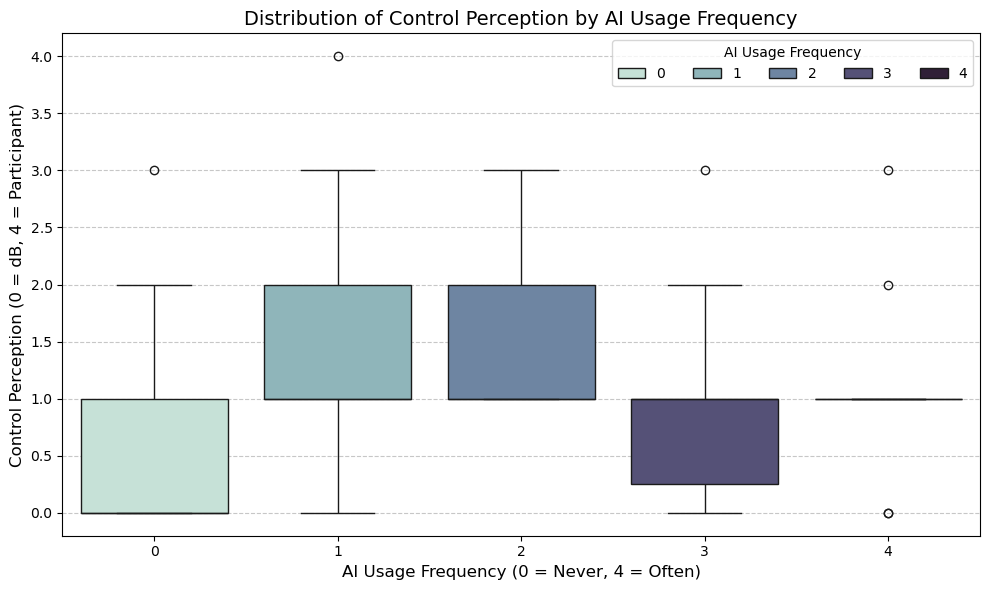

In [2556]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=combined_data,
    x="AI Usage Frequency",
    y="Control Perception",
    palette=palette,
    hue="AI Usage Frequency"
)
plt.title("Distribution of Control Perception by AI Usage Frequency", fontsize=14)
plt.xlabel("AI Usage Frequency (0 = Never, 4 = Often)", fontsize=12)
plt.ylabel("Control Perception (0 = dB, 4 = Participant)", fontsize=12)
plt.legend(title="AI Usage Frequency", loc='upper right', ncol=5)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Violin Plot
This combines the features of boxplots and density plots, highlighting the distribution and spread.

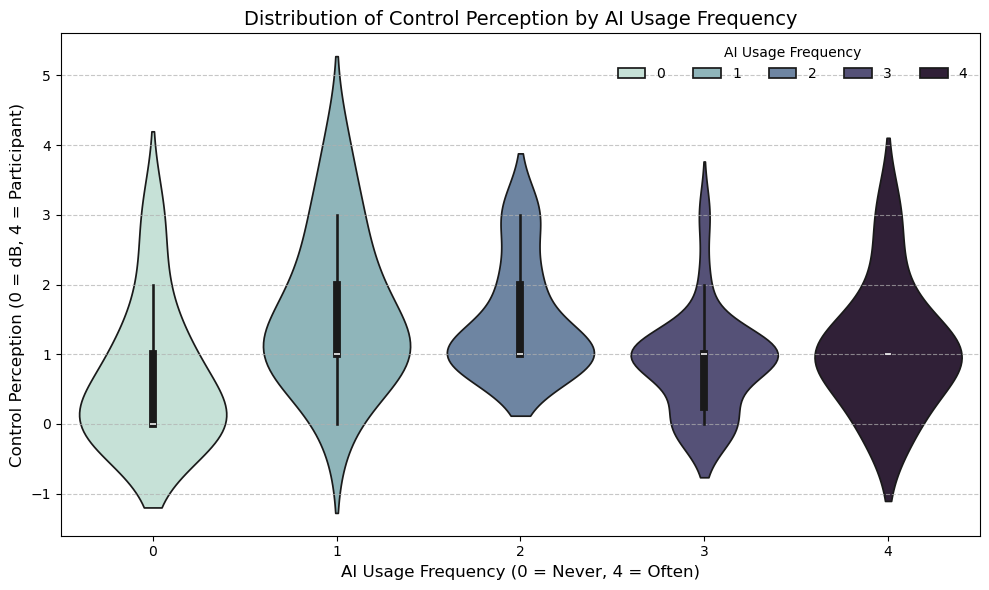

In [2558]:
plt.figure(figsize=(10, 6))
plot = sns.violinplot(
    data=combined_data,
    x="AI Usage Frequency",
    y="Control Perception",
    palette=palette,
    hue="AI Usage Frequency",
)

plt.title("Distribution of Control Perception by AI Usage Frequency", fontsize=14)
plt.xlabel("AI Usage Frequency (0 = Never, 4 = Often)", fontsize=12)
plt.ylabel("Control Perception (0 = dB, 4 = Participant)", fontsize=12)
legend = plt.legend(title="AI Usage Frequency", loc='upper right', ncol=5)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("Figures/violinplot-correlation-AI-usage-control-perception.png", transparent=True)
plt.show()

### ANOVA

Levene's test for homogeneity of variances: LeveneResult(statistic=0.5666449755283759, pvalue=0.6876452241561404)
ANOVA result: F_onewayResult(statistic=3.371758000639475, pvalue=0.013885329145603658)
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.9762 0.0441   0.017 1.9354   True
     0      2   0.8333 0.0877 -0.0753  1.742  False
     0      3    0.197 0.9697  -0.678  1.072  False
     0      4   0.4333 0.7728 -0.6106 1.4773  False
     1      2  -0.1429 0.9906 -1.0117  0.726  False
     1      3  -0.7792 0.0781 -1.6128 0.0544  False
     1      4  -0.5429 0.5626 -1.5524 0.4667  False
     2      3  -0.6364 0.1574 -1.4113 0.1386  False
     2      4     -0.4 0.7715 -1.3616 0.5616  False
     3      4   0.2364 0.9532 -0.6935 1.1663  False
---------------------------------------------------


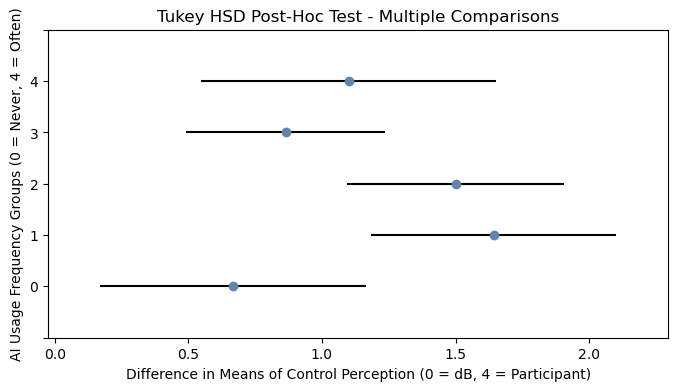

In [2604]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Check homogeneity of variances
levene_test = stats.levene(
    *[combined_data.loc[combined_data['AI Usage Frequency'] == freq, 'Control Perception'] 
      for freq in combined_data['AI Usage Frequency'].unique()]
)
print("Levene's test for homogeneity of variances:", levene_test)

# Perform one-way ANOVA
anova = stats.f_oneway(
    *[combined_data.loc[combined_data['AI Usage Frequency'] == freq, 'Control Perception'] 
      for freq in combined_data['AI Usage Frequency'].unique()]
)
print("ANOVA result:", anova)

# If significant, perform post-hoc test
if anova.pvalue < 0.05:
    tukey = pairwise_tukeyhsd(
        endog=combined_data['Control Perception'],  # Dependent variable
        groups=combined_data['AI Usage Frequency'],  # Grouping variable
        alpha=0.05  # Significance level
    )
    print(tukey) # Print tukey results as table

    # Optional visualization
    cmap = palette
    fig = tukey.plot_simultaneous(figsize =(8, 4))

    # Plot config
    for line in fig.gca().get_lines():
        line.set_color(cmap(0.5))
    plt.xlabel('Difference in Means of Control Perception (0 = dB, 4 = Participant)')
    plt.ylabel('AI Usage Frequency Groups (0 = Never, 4 = Often)')
    plt.title('Tukey HSD Post-Hoc Test - Multiple Comparisons')
    plt.savefig("Figures/tukey-HSD-correlation-AI-usage-control-perception.png", transparent=True)
    plt.show()


### Statistical Analysis (Spearman Correlation)
Likert scale data is ordinal, so using Spearman’s rank correlation coefficient is appropriate to evaluate the strength and direction of the association.

In [2562]:
from scipy.stats import spearmanr

# Calculate Spearman correlation
ai_usage = combined_data["AI Usage Frequency"]
control_perception = combined_data["Control Perception"]

rho, pval = spearmanr(ai_usage, control_perception)

print(f"Spearman Correlation: {rho:.2f}")
print(f"P-value: {pval:.4f}")

Spearman Correlation: -0.02
P-value: 0.8386


# During Study

Note to Caroline: As an initial test i wanted to checkout if i managed to get anything out of this ANOVA thing. So, i started out by looking at the one-way ANOVA test in the "during-study" and looked at the "I felt excited" data. I looked at the SessionIDs and tried to use the ANOVA test to determine if there is any sort of differences in "Excitement" between the different SessionId. It looks like there are statistical differences, revealed by the p-value, and a post-hoc analysis is required. 

We can probably look at other "feelings" and see how those look like across the SesisonIds. I guess we are using the SessionIds (the different rhythm profiles) as the base groups but idk if we should look at some other way of grouping? SessionIds seems to be alright for now, we can probably provide some analysis on that and say f.ex "people really liked the ILLIAC profile" 

In [2565]:
# Perform ANOVA on "I felt excited" across different "Session ID" groups
anova_results = stats.f_oneway(
    *[during_study[during_study['Session ID (the last session that the participant has completed)'] == session]['I felt excited']
      for session in during_study['Session ID (the last session that the participant has completed)'].unique()]
)

print("F-statistic:", anova_results.statistic)
print("p-value:", anova_results.pvalue)

F-statistic: 2.4253079621397267
p-value: 0.006674073237232363


The ANOVA test results show an F-statistic of approximately 1.76 and a p-value of 0.0066. Since the p-value is below the typical significance level (e.g., 0.05), we can conclude that there are statistically significant differences in excitement levels across the different session types.

In [2567]:
# Prepare data for Tukey's HSD test
session_data = during_study[['Session ID (the last session that the participant has completed)', 'I felt excited']].dropna()
session_data.columns = ['SessionID', 'Excitement']

tukey_results = pairwise_tukeyhsd(endog=session_data['Excitement'], groups=session_data['SessionID'], alpha=0.05)

tukey_summary = tukey_results.summary()

# Convert the summary to a pandas DataFrame for easier viewing
tukey_df = pd.DataFrame(data=tukey_summary.data[1:], columns=tukey_summary.data[0])

print(tukey_df)

# Display the results
#print(tukey_results.summary())

     group1   group2  meandiff   p-adj   lower   upper  reject
0     ALICE    ALICE   -0.9242  0.9936 -3.6453  1.7968   False
1     ALICE    Alice    0.1667  1.0000 -3.2942  3.6275   False
2     ALICE     CYSP   -1.0735  0.9786 -3.7934  1.6464   False
3     ALICE     Cysp    1.5000  0.9959 -3.1432  6.1432   False
4     ALICE   ILLIAC   -0.8188  0.9978 -3.5382  1.9005   False
5     ALICE   Illiac   -1.5000  0.9959 -6.1432  3.1432   False
6     ALICE  VOYAGER   -1.3955  0.8715 -4.1160  1.3249   False
7     ALICE    alice    0.1000  1.0000 -3.0719  3.2719   False
8     ALICE     cysp   -0.5000  1.0000 -3.5397  2.5397   False
9     ALICE   illiac   -1.1667  0.9851 -4.2621  1.9288   False
10    ALICE  voyager   -0.6111  0.9999 -3.5748  2.3526   False
11    ALICE    Alice    1.0909  0.9058 -1.1471  3.3289   False
12    ALICE     CYSP   -0.1493  0.9998 -0.8044  0.5058   False
13    ALICE     Cysp    2.4242  0.6296 -1.3955  6.2440   False
14    ALICE   ILLIAC    0.1054  1.0000 -0.5473  0.7581 

# Post Study